In [93]:
from pathlib import Path
from typing import Callable, Tuple, Dict, Iterable
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import matplotlib.pyplot as plt

# from kalman_reconstruction.kalman import (
#     Kalman_SEM,
# )
from kalman_reconstruction import pipeline
from kalman_reconstruction.custom_plot import (
    plot_state_with_probability,
    set_custom_rcParams,
)
from kalman_reconstruction.statistics import (
    normalize,
    autocorr,
)

set_custom_rcParams()
plt.rcParams["figure.figsize"] = (8, 5)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from reconstruct_climate_indices.idealized_ocean import AMO_oscillatory_ocean
from reconstruct_climate_indices.track_data import track_model
from tqdm import tqdm

In [4]:
SUBDATA_PATH = "AMO_oscillator_V2"
PATH_FIGURES = Path("../results/AMO_oscillator_V2")
SAVE_FIGURES = True


def save_fig(fig, relative_path, **kwargs):
    if SAVE_FIGURES:
        fig.savefig(PATH_FIGURES / relative_path, **kwargs)
    else:
        pass

In [5]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

In [6]:
default_settings = dict(
    nt=1000,  # timesteps
    dt=30,  # days
    per0=24 * 365.25,  # days
    tau0=10 * 365.25,  # days
    dNAO=0.1,
    dEAP=0.1,
    cNAOvsEAP=0,
    save_path=None,
    return_settings=True,
)
setting = default_settings.copy()
select_dict = {key: default_settings[key] for key in ["dNAO", "dEAP", "cNAOvsEAP"]}

factor = np.array([[0.1], [0.5], [1], [5]])
experiment_settings = dict()
experiment_settings_flat = dict()
for key in ["dNAO", "dEAP"]:
    experiment_settings[key] = default_settings[key] * factor
    experiment_settings_flat[key] = default_settings[key] * factor.flatten()

all_experiment_settings = list(product_dict(**experiment_settings_flat))

data_list = []
for s in tqdm(all_experiment_settings):
    setting.update(**s)
    data = track_model(
        func=AMO_oscillatory_ocean, 
        mlflow_args=dict(experiment_id="286934939241168502"),
        func_kwargs=setting, subdata_path=SUBDATA_PATH
    )
    data_list.append(data)



100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


In [7]:
experiments = xr.merge(data_list)
experiments

<xarray.Dataset>
Dimensions:     (time: 1000, dEAP: 4, dNAO: 4, cNAOvsEAP: 1)
Coordinates:
  * time        (time) int32 0 30 60 90 120 ... 29850 29880 29910 29940 29970
  * dEAP        (dEAP) float64 0.01 0.05 0.1 0.5
  * dNAO        (dNAO) float64 0.01 0.05 0.1 0.5
  * cNAOvsEAP   (cNAOvsEAP) int32 0
    time_years  (time) float64 0.0 0.08214 0.1643 0.2464 ... 81.89 81.97 82.05
Data variables:
    AMO         (time, dEAP, dNAO, cNAOvsEAP) float64 0.0 0.0 ... -10.03 -9.928
    EAP         (time, dEAP, dNAO, cNAOvsEAP) float64 0.0 0.0 ... 0.336 0.336
    NAO         (time, dEAP, dNAO, cNAOvsEAP) float64 0.0 0.0 ... 0.0339 0.1695
    ZOT         (time, dEAP, dNAO, cNAOvsEAP) float64 0.0 0.0 ... -2.972 -3.339
Attributes:
    coder:    Florian Sévellec <florian.sevellec@univ-brest.fr>

4it [00:00,  7.25it/s]


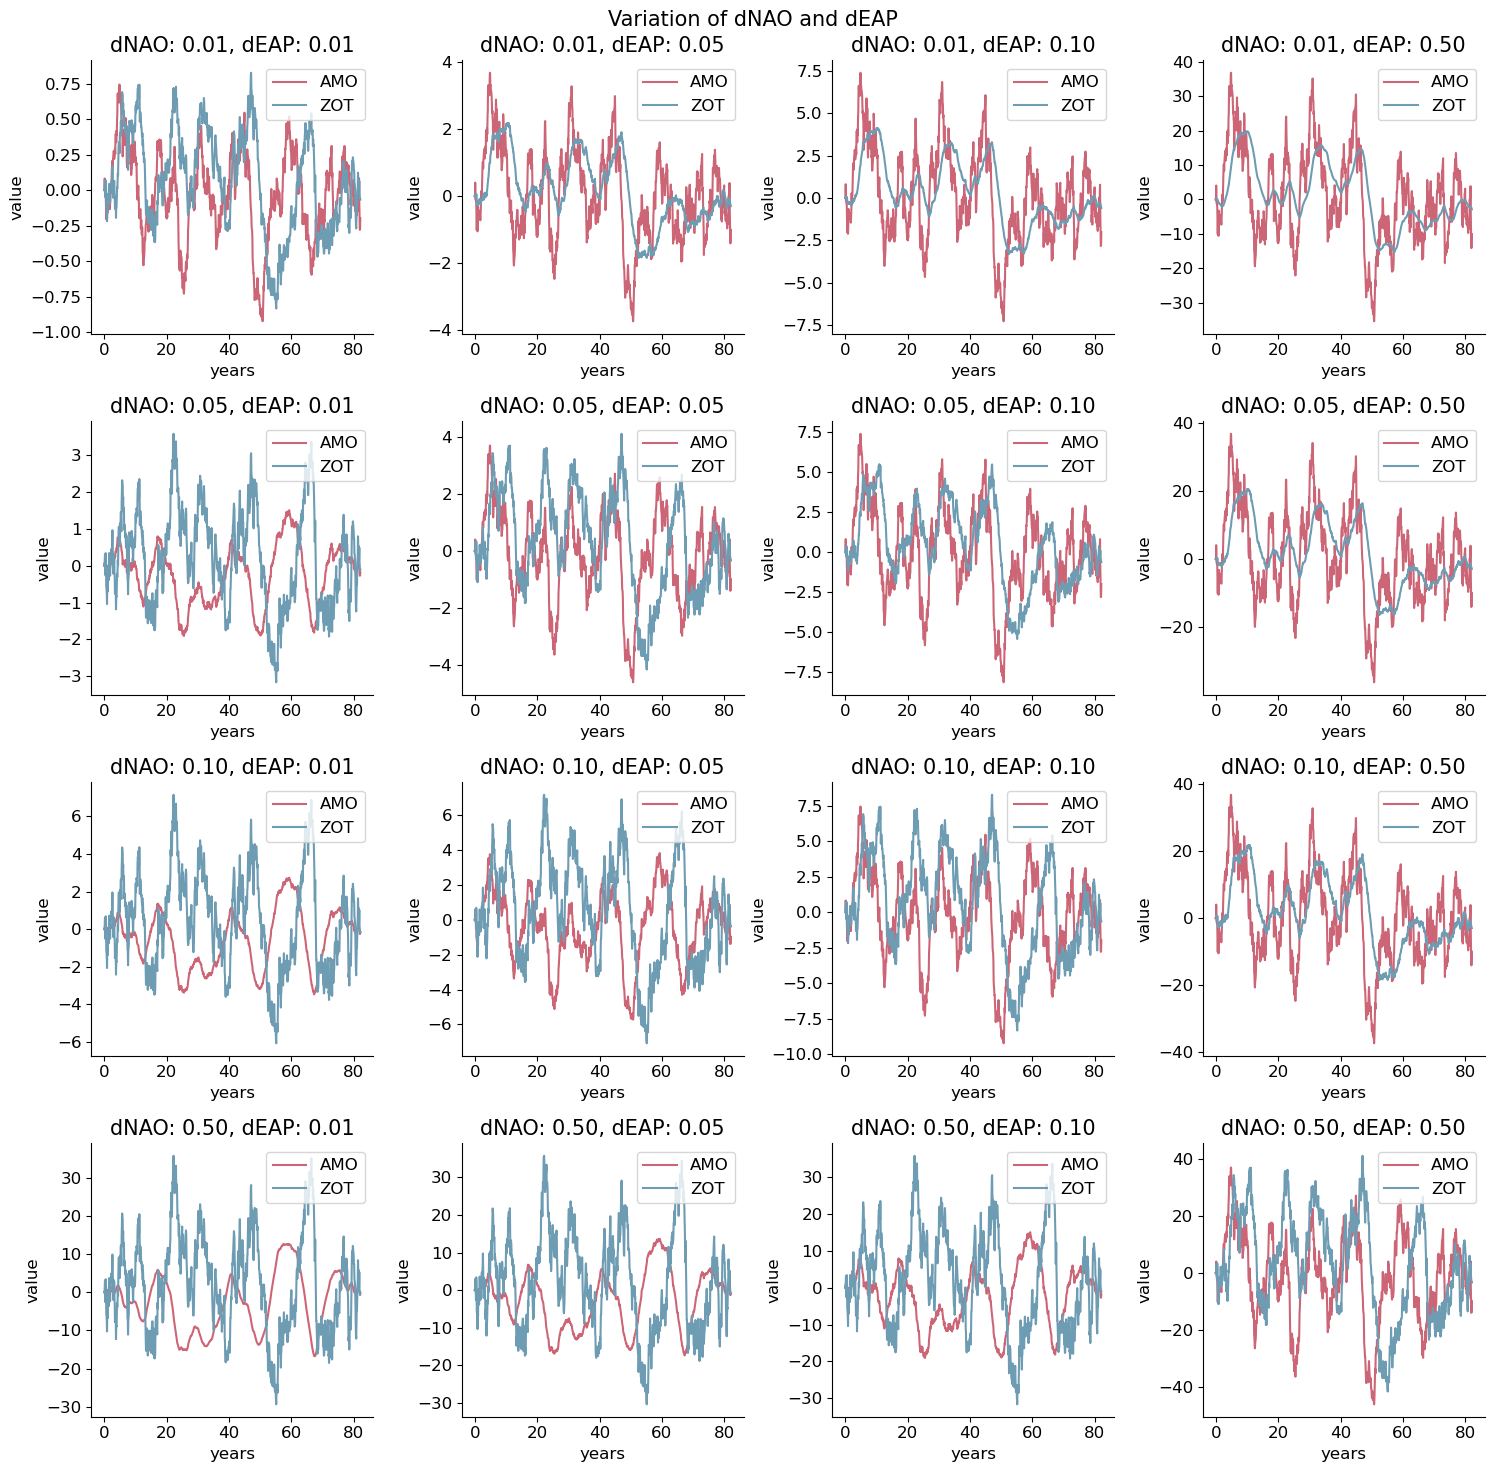

In [119]:
fig, axs = plt.subplots(
    nrows = len(experiments.dNAO), 
    ncols = len(experiments.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments.dNAO)):
    for j, dEAP in enumerate(experiments.dEAP):
        axs[i,j].plot(experiments.time_years, experiments["AMO"].sel(dNAO = dNAO, dEAP = dEAP), label = "AMO")
        axs[i,j].plot(experiments.time_years, experiments["ZOT"].sel(dNAO = dNAO, dEAP = dEAP), label = "ZOT")
        axs[i,j].set_title(f"dNAO: {dNAO:.2f}, dEAP: {dEAP:.2f}")
        axs[i,j].set_ylabel("value")
        axs[i,j].set_xlabel("years")
        axs[i,j].legend()

fig.suptitle("Variation of dNAO and dEAP")
fig.tight_layout()

4it [00:00, 11.11it/s]


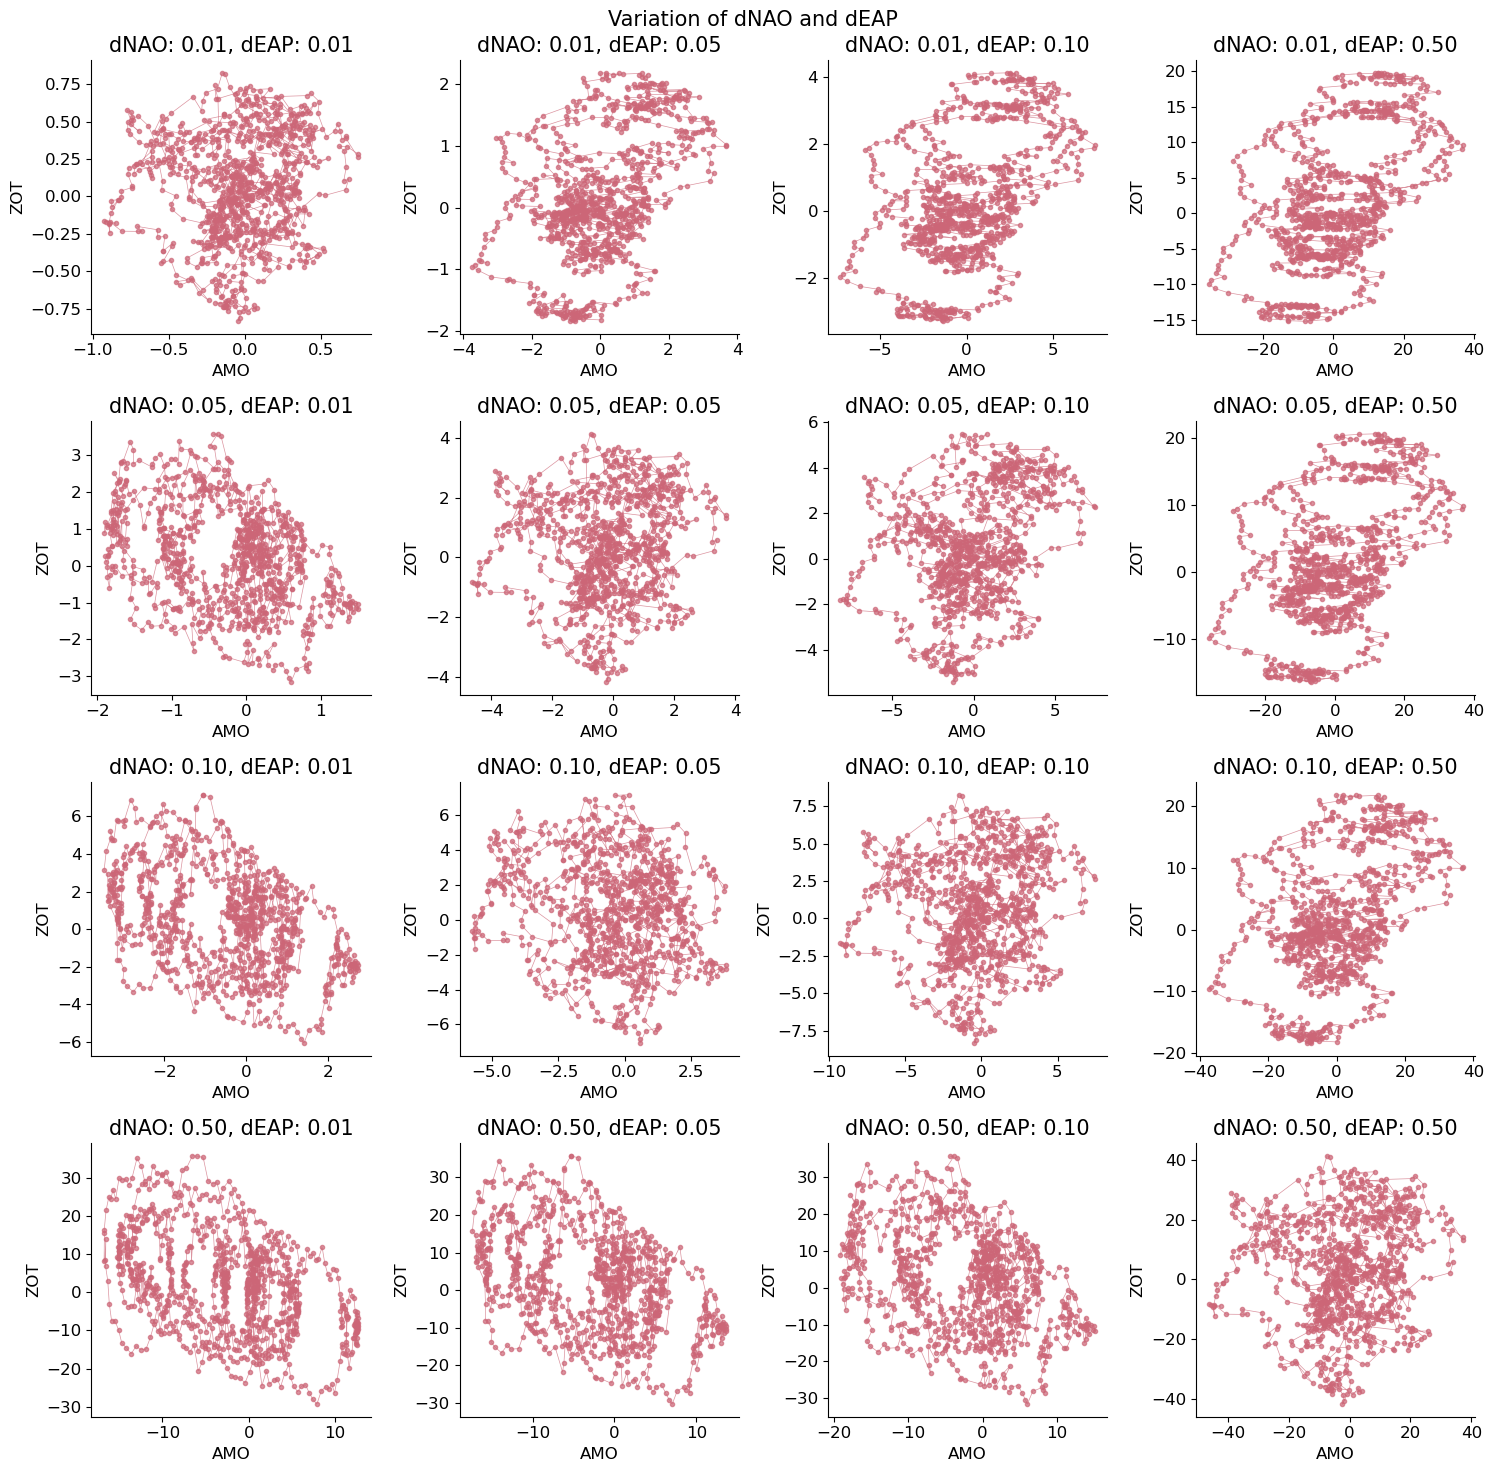

In [121]:
fig, axs = plt.subplots(
    nrows = len(experiments.dNAO), 
    ncols = len(experiments.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments.dNAO)):
    for j, dEAP in enumerate(experiments.dEAP):
        axs[i,j].plot(
            experiments["AMO"].sel(dNAO = dNAO, dEAP = dEAP),
            experiments["ZOT"].sel(dNAO = dNAO, dEAP = dEAP),
            linestyle = "-", linewidth = 0.5, marker = ".", alpha = 0.7,
            )
        axs[i,j].set_title(f"dNAO: {dNAO:.2f}, dEAP: {dEAP:.2f}")
        axs[i,j].set_ylabel("ZOT")
        axs[i,j].set_xlabel("AMO")

fig.suptitle("Variation of dNAO and dEAP")
fig.tight_layout()

4it [00:00, 10.19it/s]


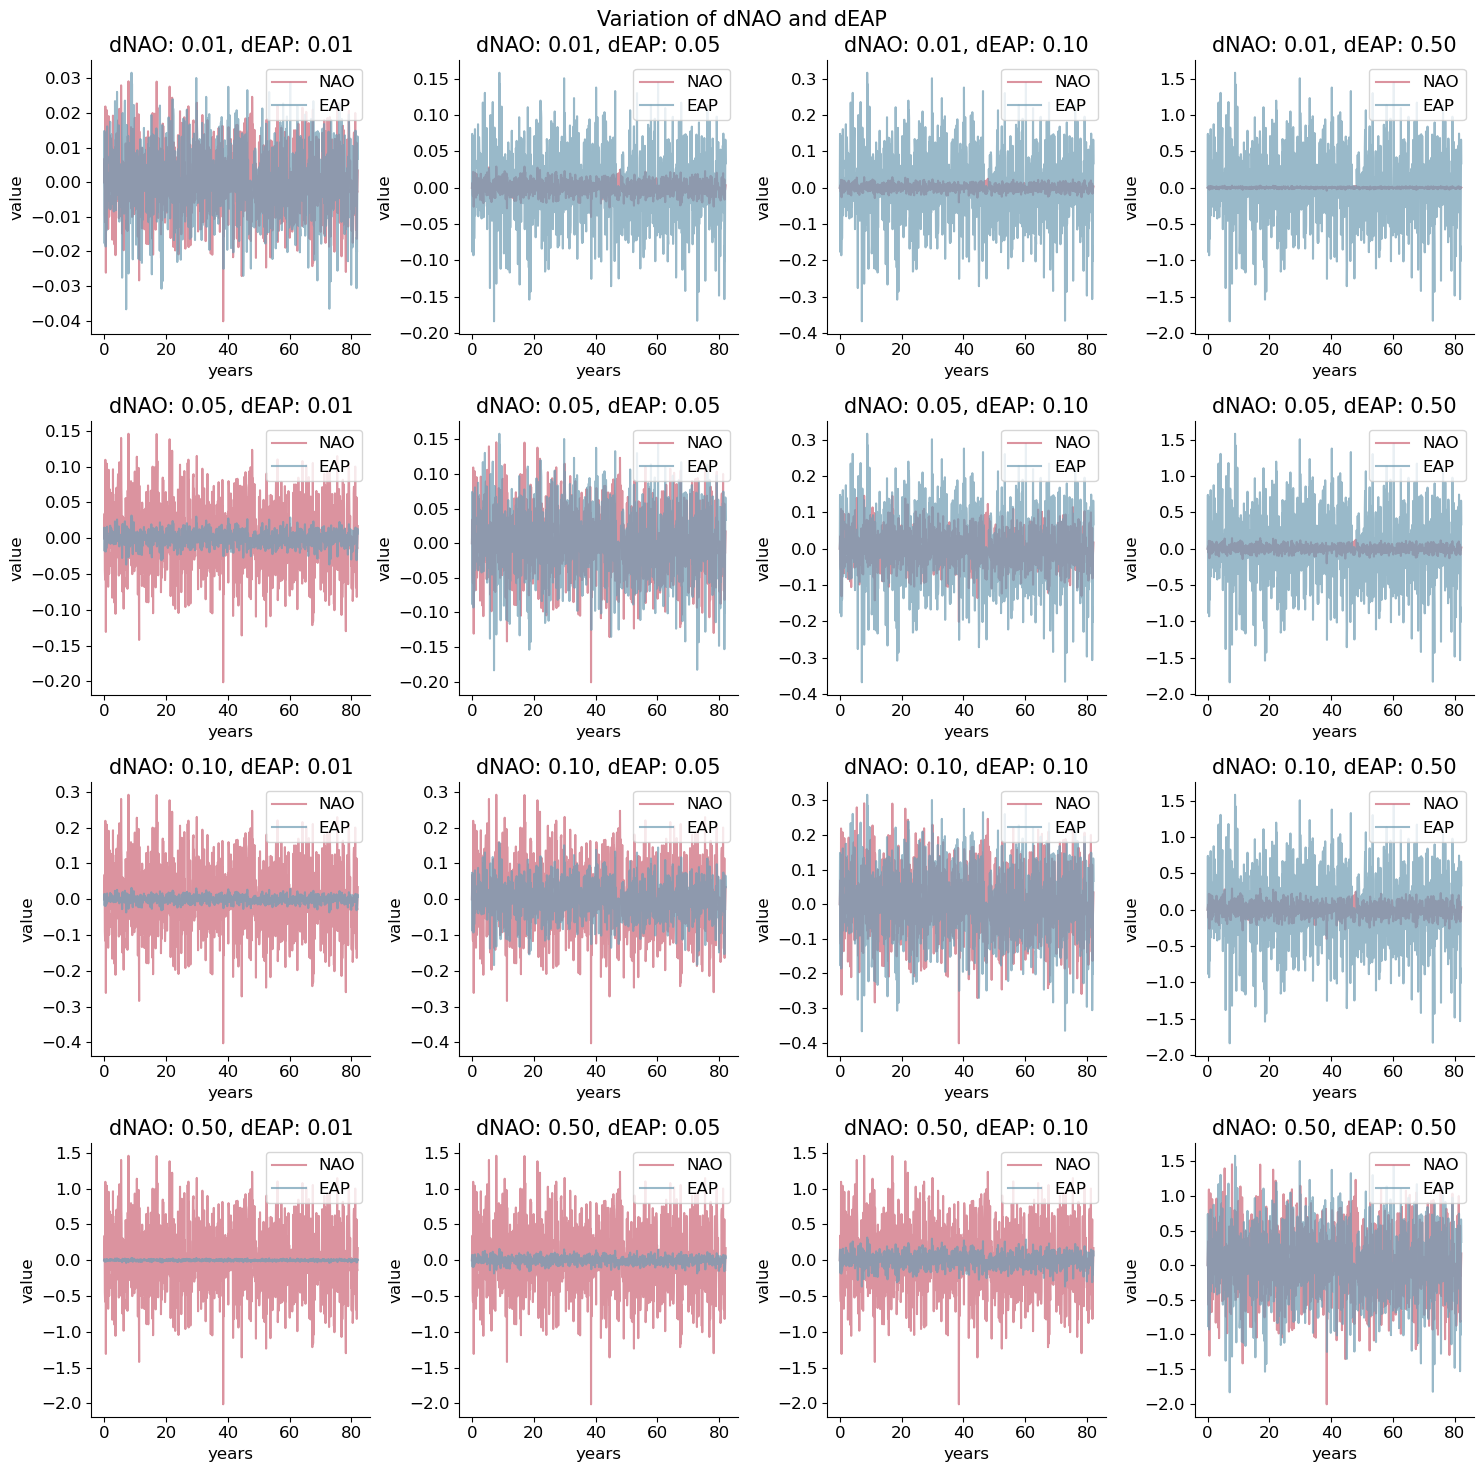

In [22]:
fig, axs = plt.subplots(
    nrows = len(experiments.dNAO), 
    ncols = len(experiments.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments.dNAO)):
    for j, dEAP in enumerate(experiments.dEAP):
        axs[i,j].plot(experiments.time_years, experiments["NAO"].sel(dNAO = dNAO, dEAP = dEAP), label = "NAO", alpha = 0.7)
        axs[i,j].plot(experiments.time_years, experiments["EAP"].sel(dNAO = dNAO, dEAP = dEAP), label = "EAP", alpha = 0.7)
        axs[i,j].set_title(f"dNAO: {dNAO:.2f}, dEAP: {dEAP:.2f}")
        axs[i,j].set_ylabel("value")
        axs[i,j].set_xlabel("years")
        axs[i,j].legend()

fig.suptitle("Variation of dNAO and dEAP")
fig.tight_layout()

Code to run the Kalman Itteration for all experiments

In [108]:
seed = 39264
variance = 5
nb_iter_SEM = 3
forcast_duration = 0.5

rng1 = np.random.default_rng(seed=seed)
rng2 = np.random.default_rng(seed=seed + 1)
rng3 = np.random.default_rng(seed=seed + 2)
rng4 = np.random.default_rng(seed=seed + 3)

Create Dataset for kalman_results

In [109]:
observation_variables=["AMO", "NAO", "EAP"]
state_variables=["AMO", "NAO", "EAP", "latent"]
data_1_latent = experiments.copy()
pipeline.add_random_variable(ds = data_1_latent, var_name="latent", random_generator=rng3, variance = 1)

mlflow_args=dict()
func_args = dict()
func_kwargs = dict(
    observation_variables=observation_variables,
    state_variables=state_variables,
    nb_iter_SEM=nb_iter_SEM
    )

select_dicts = all_experiment_settings[:]
experiments_kalman = pipeline.run_function_on_multiple_subdatasets(
    processing_function = pipeline.xarray_Kalman_SEM,
    parent_dataset=data_1_latent,
    subdataset_selections=select_dicts,
    func_args=func_args,
    func_kwargs=func_kwargs
)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


In [110]:
experiments_kalman_states = pipeline.from_standard_dataset(experiments_kalman, "states")
experiments_kalman

<xarray.Dataset>
Dimensions:            (time: 1000, state_name: 4, state_name_copy: 4,
                        kalman_itteration: 3, cNAOvsEAP: 1, dEAP: 4, dNAO: 4)
Coordinates:
  * time               (time) int32 0 30 60 90 120 ... 29880 29910 29940 29970
  * state_name         (state_name) <U6 'AMO' 'NAO' 'EAP' 'latent'
  * state_name_copy    (state_name_copy) <U6 'AMO' 'NAO' 'EAP' 'latent'
  * kalman_itteration  (kalman_itteration) int32 0 1 2
  * cNAOvsEAP          (cNAOvsEAP) int32 0
  * dEAP               (dEAP) float64 0.01 0.05 0.1 0.5
  * dNAO               (dNAO) float64 0.01 0.05 0.1 0.5
    time_years         (time) float64 0.0 0.08214 0.1643 ... 81.89 81.97 82.05
Data variables:
    states             (dNAO, dEAP, time, state_name) float64 -0.4878 ... 0.1066
    covariance         (dNAO, dEAP, time, state_name, state_name_copy) float64 ...
    M                  (dNAO, dEAP, state_name, state_name_copy) float64 0.98...
    Q                  (dNAO, dEAP, state_name, state_name_copy) float64 0.00...
    log_likelihod      (dNAO, dEAP, kalman_itteration) float64 7.236e+03 ... ...

4it [00:00,  6.60it/s]


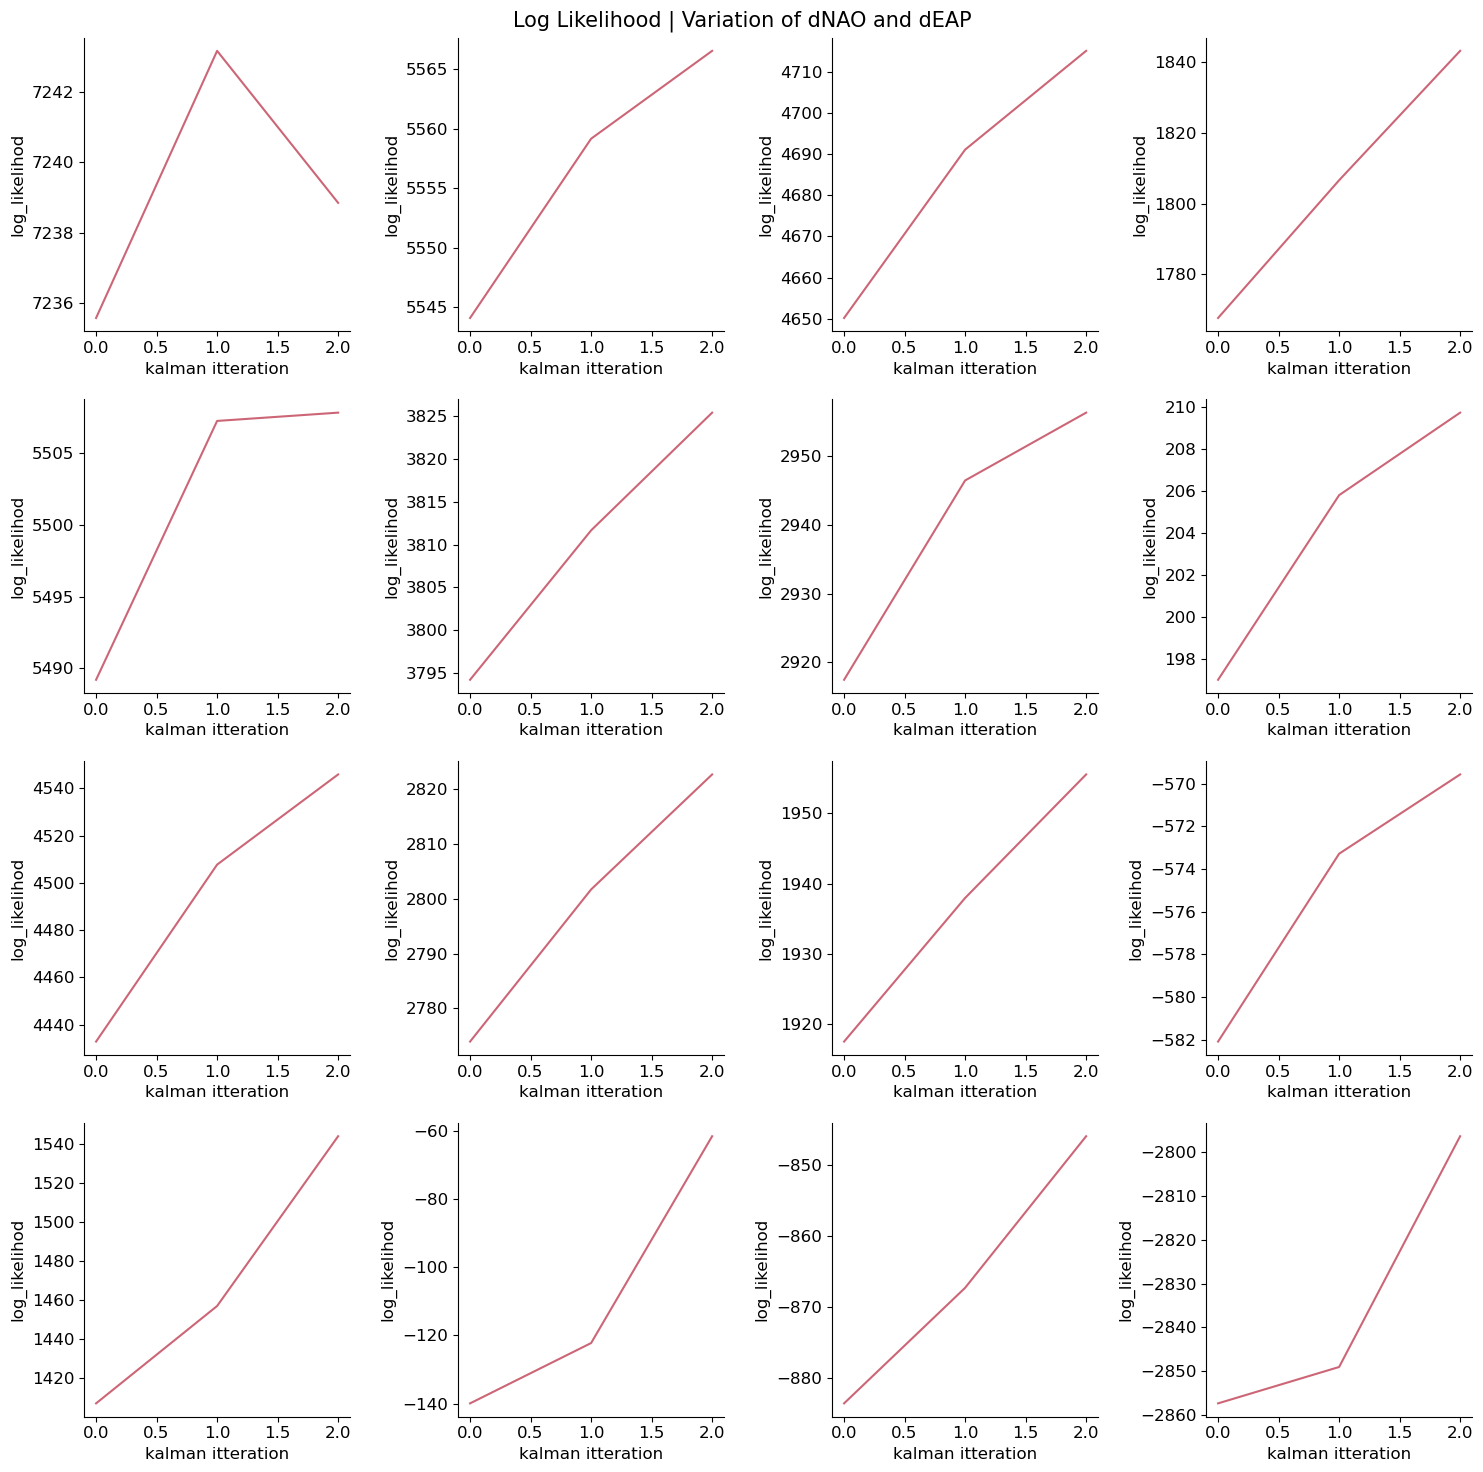

In [111]:
experiments_kalman_states = normalize(experiments_kalman_states)
fig, axs = plt.subplots(
    nrows = len(experiments_kalman_states.dNAO), 
    ncols = len(experiments_kalman_states.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments_kalman_states.dNAO)):
    for j, dEAP in enumerate(experiments_kalman_states.dEAP):
        reconst = experiments_kalman.sel(dNAO = dNAO, dEAP = dEAP, method='nearest')
        axs[i,j].plot(reconst["kalman_itteration"], reconst["log_likelihod"])
        axs[i,j].set_ylabel("log_likelihod")
        axs[i,j].set_xlabel("kalman itteration")

fig.suptitle("Log Likelihood | Variation of dNAO and dEAP")
fig.tight_layout()


4it [00:01,  2.45it/s]


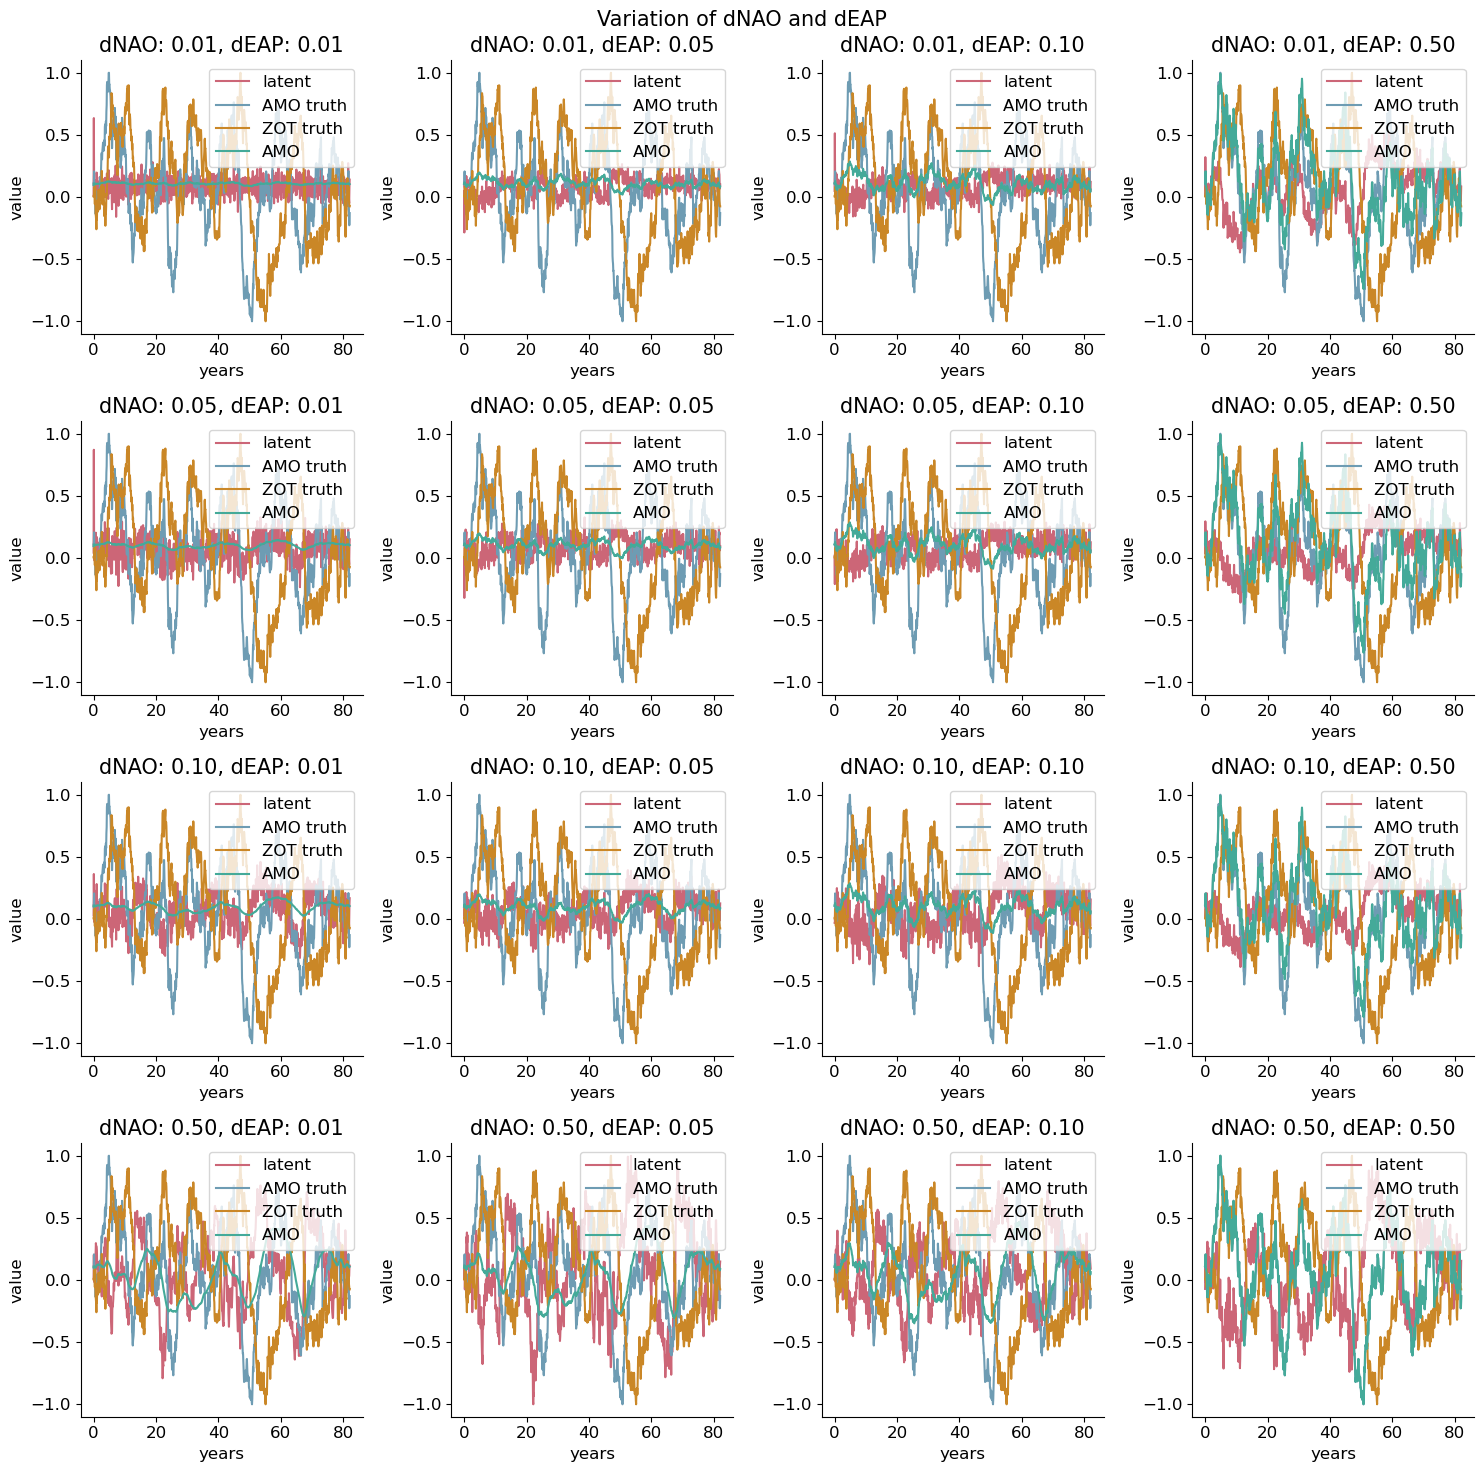

In [112]:
experiments_kalman_states = normalize(experiments_kalman_states)
fig, axs = plt.subplots(
    nrows = len(experiments_kalman_states.dNAO), 
    ncols = len(experiments_kalman_states.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments_kalman_states.dNAO)):
    for j, dEAP in enumerate(experiments_kalman_states.dEAP):
        axs[i,j].plot(experiments_kalman_states.time_years, experiments_kalman_states["latent"].sel(dNAO = dNAO, dEAP = dEAP, method='nearest'), label = "latent")
        axs[i,j].plot(data.time_years, normalize(data["AMO"]).sel(dNAO = dNAO, dEAP = dEAP, method='nearest'), label = "AMO truth")
        axs[i,j].plot(data.time_years, normalize(data["ZOT"]).sel(dNAO = dNAO, dEAP = dEAP, method='nearest'), label = "ZOT truth")
        try : 
            axs[i,j].plot(experiments_kalman_states.time_years, experiments_kalman_states["ZOT"].sel(dNAO = dNAO, dEAP = dEAP, method='nearest'), label = "ZOT")
        except Exception as e:
            pass
        try : 
            axs[i,j].plot(experiments_kalman_states.time_years, experiments_kalman_states["AMO"].sel(dNAO = dNAO, dEAP = dEAP, method='nearest'), label = "AMO")
        except Exception as e:
            pass
        
        
        
        axs[i,j].set_title(f"dNAO: {dNAO:.2f}, dEAP: {dEAP:.2f}")
        axs[i,j].set_ylabel("value")
        axs[i,j].set_xlabel("years")
        axs[i,j].legend()

fig.suptitle("Variation of dNAO and dEAP")
fig.tight_layout()

4it [00:02,  1.85it/s]


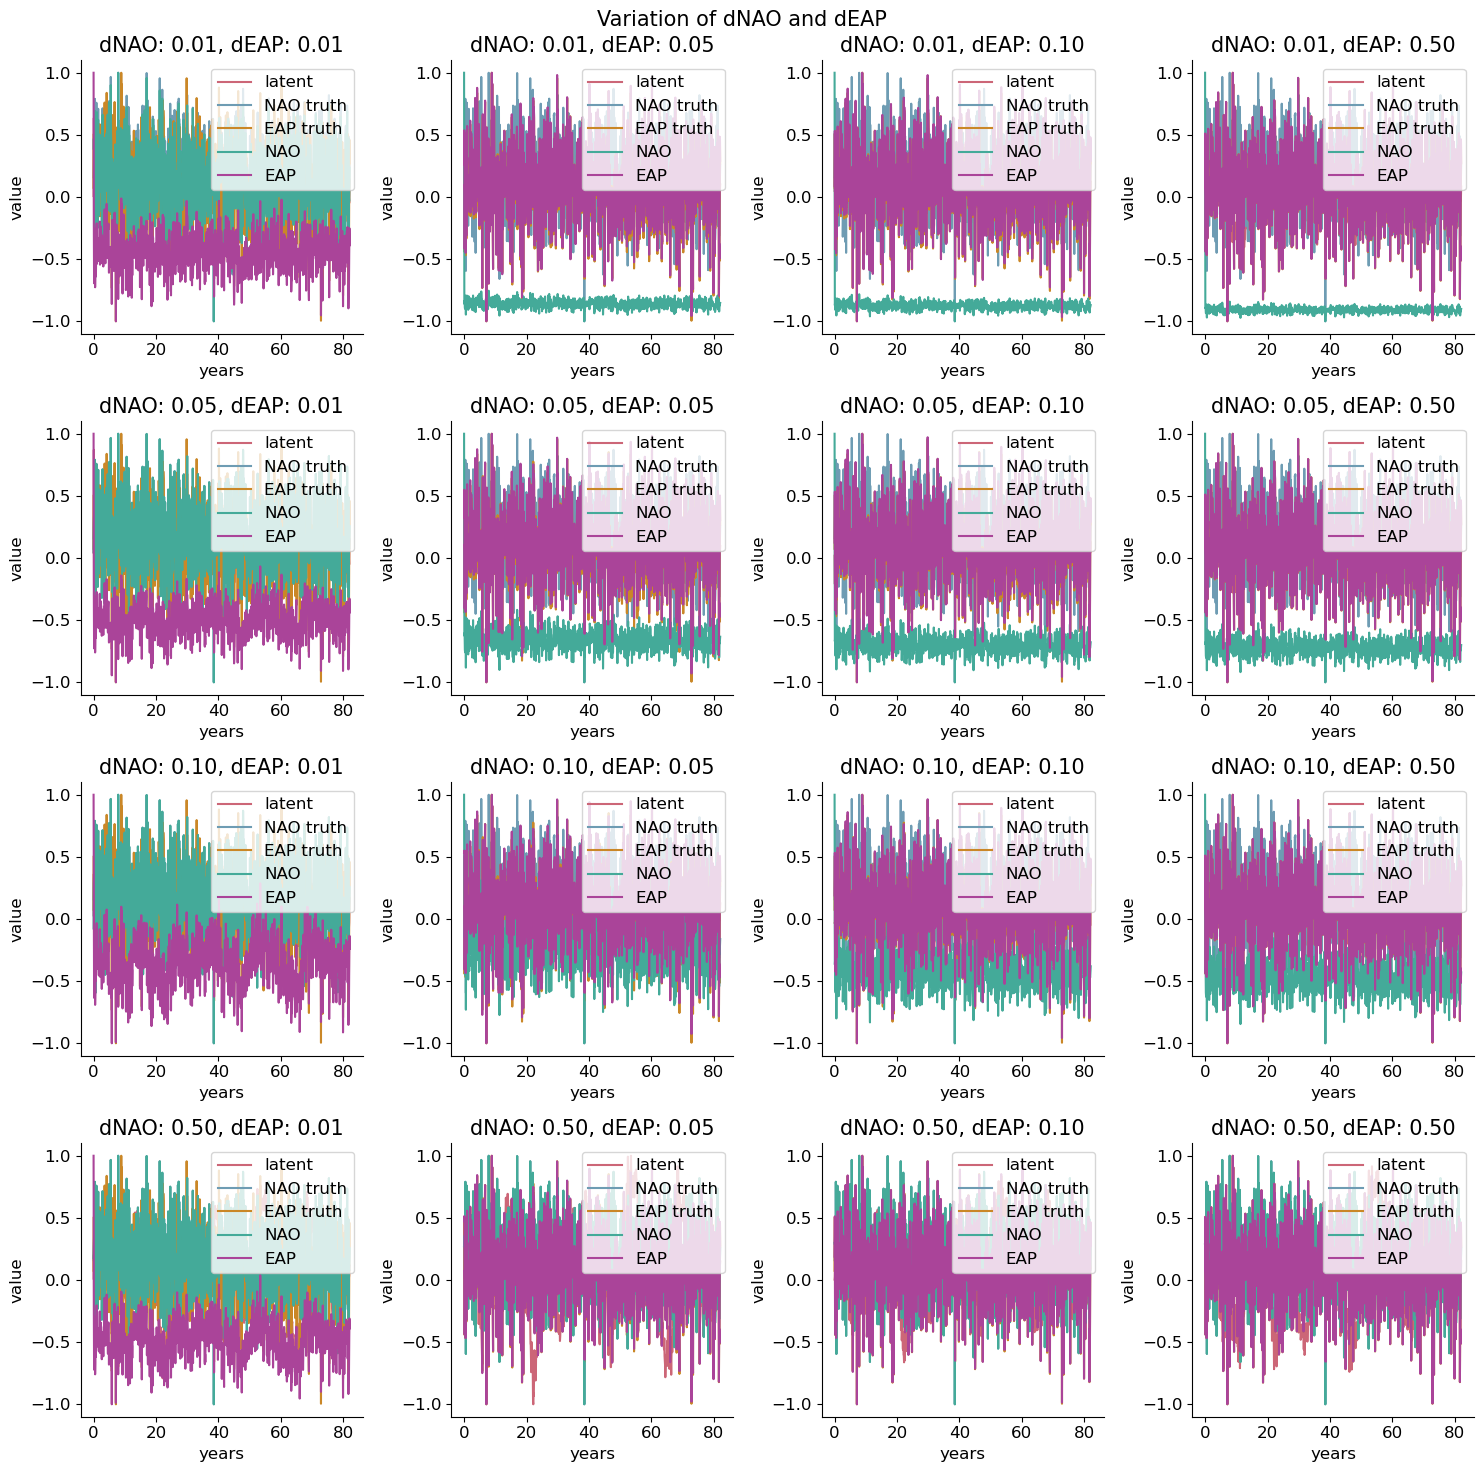

In [116]:
experiments_kalman_states = normalize(experiments_kalman_states)
fig, axs = plt.subplots(
    nrows = len(experiments_kalman_states.dNAO), 
    ncols = len(experiments_kalman_states.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments_kalman_states.dNAO)):
    for j, dEAP in enumerate(experiments_kalman_states.dEAP):
        axs[i,j].plot(experiments_kalman_states.time_years, experiments_kalman_states["latent"].sel(dNAO = dNAO, dEAP = dEAP, method='nearest'), label = "latent")
        axs[i,j].plot(data.time_years, normalize(data["NAO"]).sel(dNAO = dNAO, dEAP = dEAP, method='nearest'), label = "NAO truth")
        axs[i,j].plot(data.time_years, normalize(data["EAP"]).sel(dNAO = dNAO, dEAP = dEAP, method='nearest'), label = "EAP truth")
        try : 
            axs[i,j].plot(experiments_kalman_states.time_years, normalize(experiments_kalman_states["NAO"].sel(dNAO = dNAO, dEAP = dEAP, method='nearest')), label = "NAO")
        except Exception as e:
            pass
        try : 
            axs[i,j].plot(experiments_kalman_states.time_years, normalize(experiments_kalman_states["EAP"].sel(dNAO = dNAO, dEAP = dEAP, method='nearest')), label = "EAP")
        except Exception as e:
            pass
        
        
        
        axs[i,j].set_title(f"dNAO: {dNAO:.2f}, dEAP: {dEAP:.2f}")
        axs[i,j].set_ylabel("value")
        axs[i,j].set_xlabel("years")
        axs[i,j].legend()

fig.suptitle("Variation of dNAO and dEAP")
fig.tight_layout()

4it [00:01,  2.63it/s]


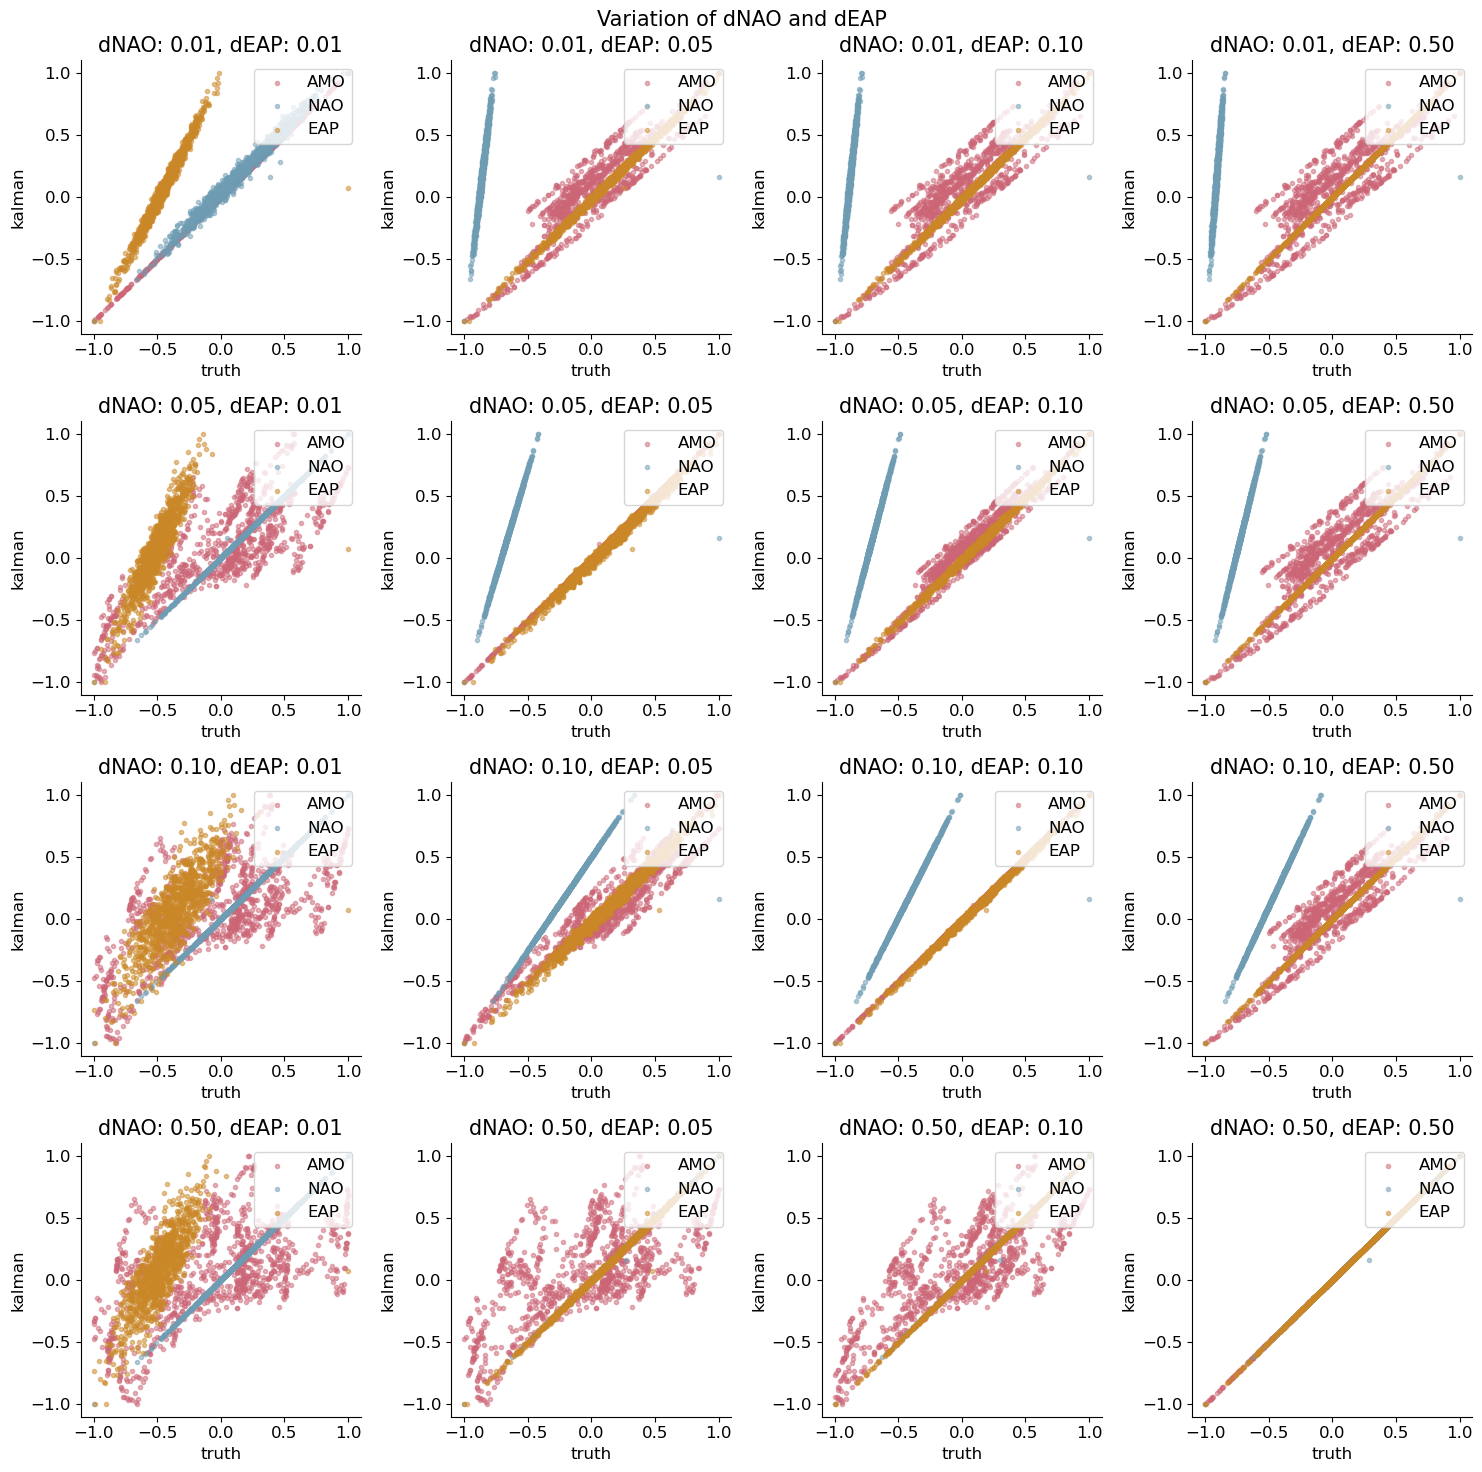

In [113]:
experiments_kalman_states = normalize(experiments_kalman_states)
fig, axs = plt.subplots(
    nrows = len(experiments_kalman_states.dNAO), 
    ncols = len(experiments_kalman_states.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments_kalman_states.dNAO)):
    for j, dEAP in enumerate(experiments_kalman_states.dEAP):
        reconst = normalize(experiments_kalman_states.sel(dNAO = dNAO, dEAP = dEAP, method='nearest'))
        truth = normalize(data.sel(dNAO = dNAO, dEAP = dEAP, method='nearest'))
        for state in observation_variables:
            axs[i,j].scatter(
                reconst[state], 
                truth[state], 
                marker = ".",
                alpha = 0.5, label = state,
                )
        axs[i,j].set_title(f"dNAO: {dNAO:.2f}, dEAP: {dEAP:.2f}")
        axs[i,j].set_xlabel("truth")
        axs[i,j].set_ylabel("kalman")
        axs[i,j].legend()

fig.suptitle("Variation of dNAO and dEAP")
fig.tight_layout()


4it [00:00, 10.00it/s]


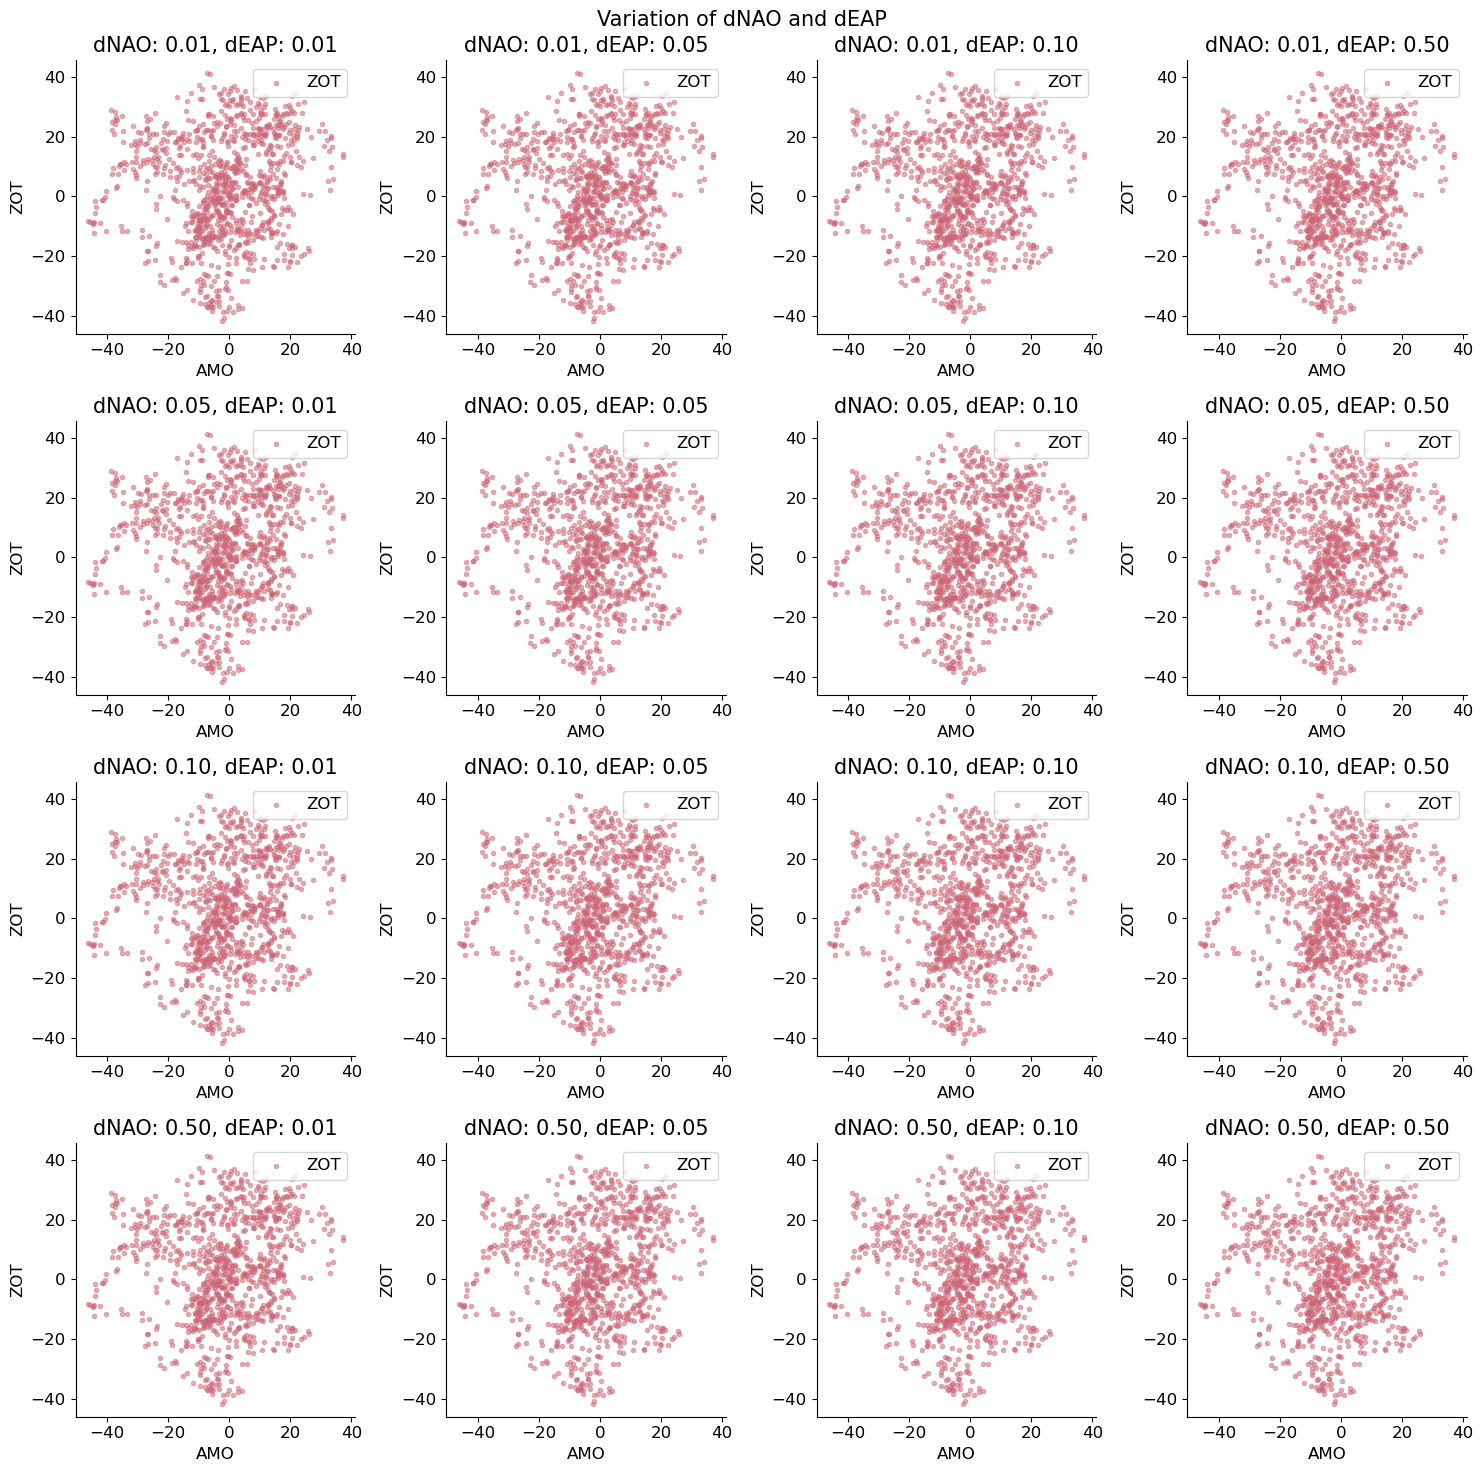

In [118]:
fig, axs = plt.subplots(
    nrows = len(experiments_kalman_states.dNAO), 
    ncols = len(experiments_kalman_states.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments_kalman_states.dNAO)):
    for j, dEAP in enumerate(experiments_kalman_states.dEAP):
        truth = (data.sel(dNAO = dNAO, dEAP = dEAP, method='nearest'))
        axs[i,j].scatter(
            truth["AMO"], 
            truth["ZOT"], 
            marker = ".",
            alpha = 0.5, label = state,
            )
        axs[i,j].set_title(f"dNAO: {dNAO:.2f}, dEAP: {dEAP:.2f}")
        axs[i,j].set_xlabel("AMO")
        axs[i,j].set_ylabel("ZOT")
        axs[i,j].legend()

fig.suptitle("Variation of dNAO and dEAP")
fig.tight_layout()


4it [00:04,  1.17s/it]


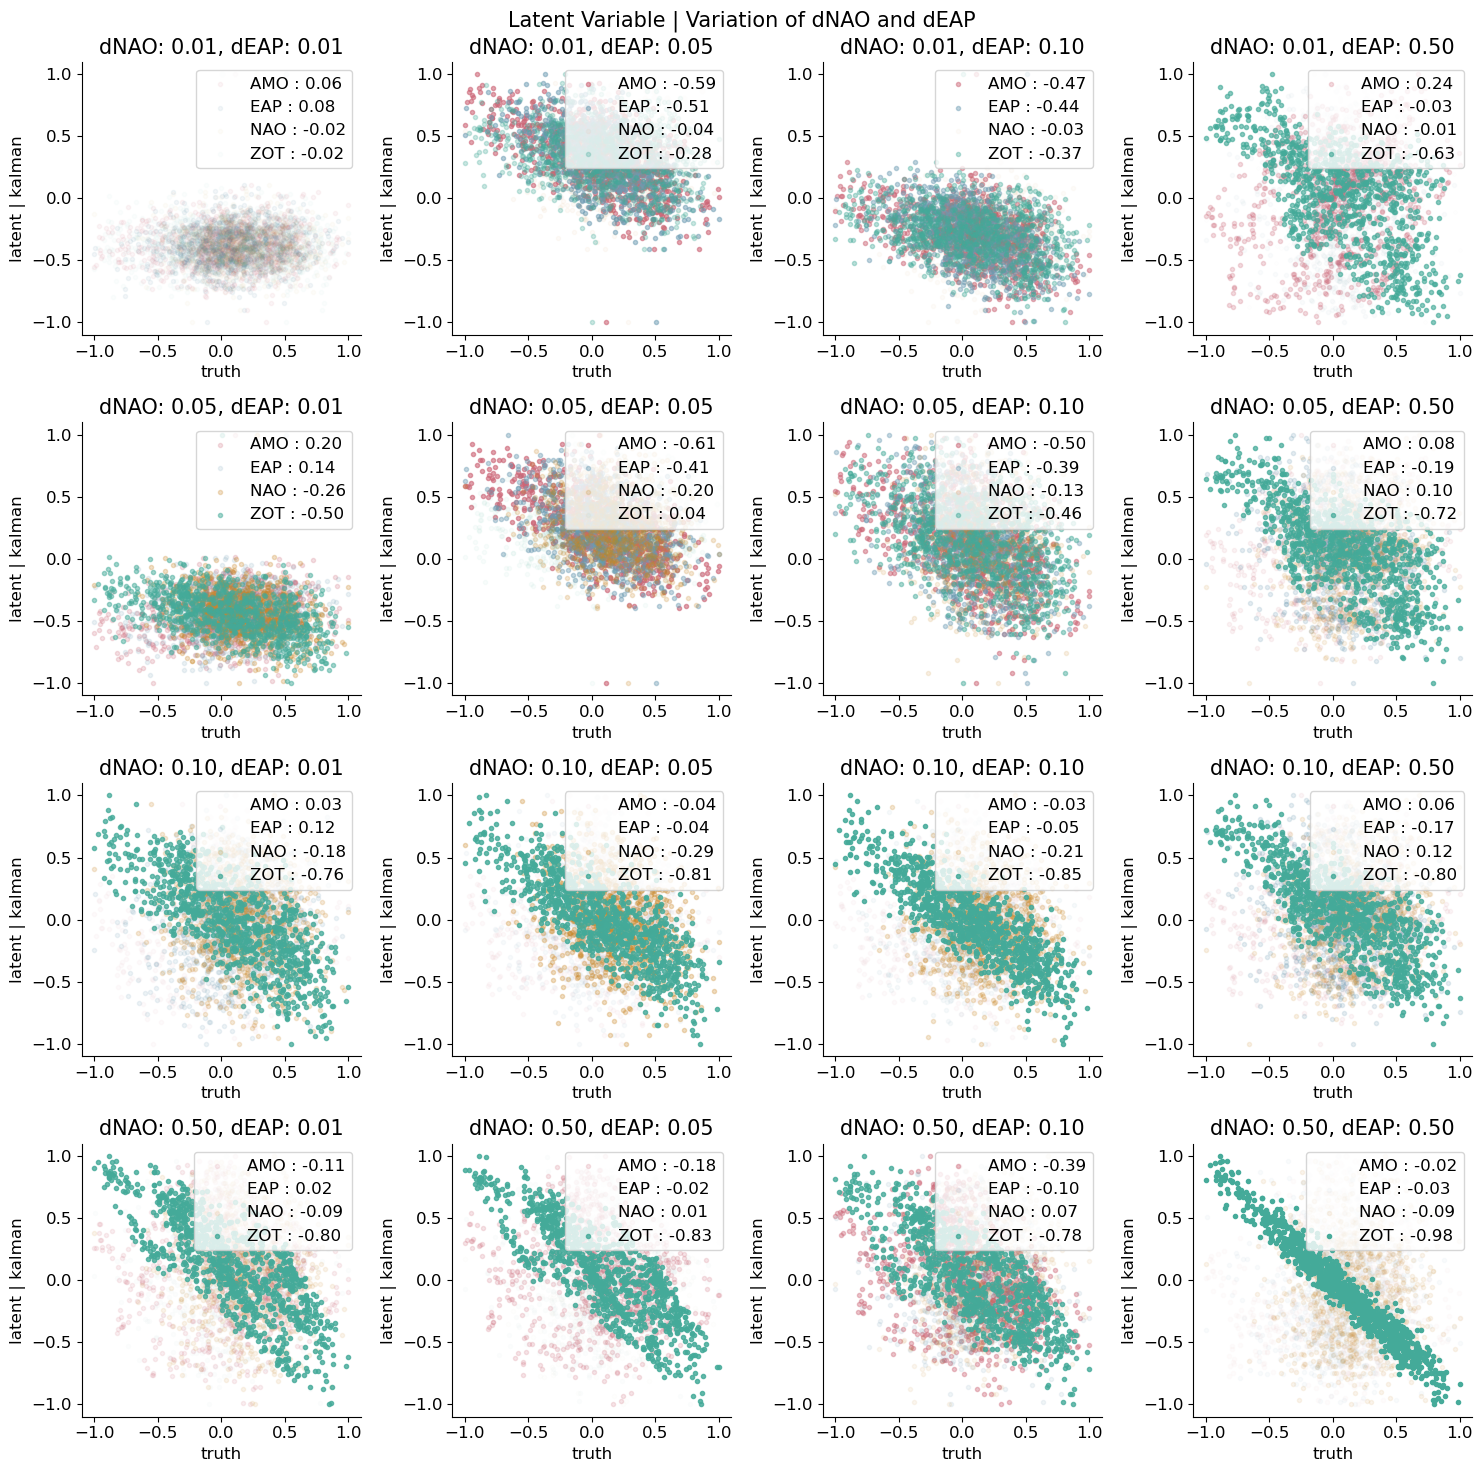

In [114]:
experiments_kalman_states = normalize(experiments_kalman_states)
fig, axs = plt.subplots(
    nrows = len(experiments_kalman_states.dNAO), 
    ncols = len(experiments_kalman_states.dEAP),
    figsize = (15,15))
for i, dNAO in tqdm(enumerate(experiments_kalman_states.dNAO)):
    for j, dEAP in enumerate(experiments_kalman_states.dEAP):
        reconst = normalize(experiments_kalman_states.sel(dNAO = dNAO, dEAP = dEAP, method='nearest'))
        truth = normalize(data.sel(dNAO = dNAO, dEAP = dEAP, method='nearest'))
        for state in data.data_vars:
            corr = xr.corr(truth[state], reconst["latent"])
            axs[i,j].scatter(
                truth[state], 
                reconst["latent"],
                marker = ".",
                alpha = np.abs(corr.values), label = f"{state} : {corr:.2f}")
        axs[i,j].set_title(f"dNAO: {dNAO:.2f}, dEAP: {dEAP:.2f}")
        axs[i,j].set_xlabel("truth")
        axs[i,j].set_ylabel("latent | kalman")
        axs[i,j].legend()

fig.suptitle("Latent Variable | Variation of dNAO and dEAP")
fig.tight_layout()
